In [8]:
# =========================================================
# Aureus Sigma Capital - Vietnam Market Liquidity Deep Dive Analysis
# Notebook: 10_liquidity_deep_dive.ipynb
#
# Description:
# Comprehensive institutional-grade quantitative analysis of
# Vietnamese stock market liquidity (2018-2025) to determine optimal ADTV 
# threshold for production trading strategies. Three-tier analysis: 
# market overview, concentration metrics, and universe composition by 
# liquidity thresholds.
#
# Author: Duc Nguyen, Quantitative Finance Expert
# Date: July 27, 2025
# Version: 1.0 - Production Implementation
# =========================================================

# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from sqlalchemy import create_engine, text
from typing import Dict, List, Tuple, Optional
import yaml
from pathlib import Path
import gc

warnings.filterwarnings('ignore')

# --- BLACKSTONE-INSPIRED INSTITUTIONAL PALETTE ---
FACTOR_COLORS = {
    'Strategy': '#16A085',          # Blackstone Teal (primary)
    'Benchmark': '#34495E',         # Warm charcoal (secondary)
    'Positive': '#27AE60',          # Professional green
    'Negative': '#C0392B',          # Sophisticated red
    'Drawdown': '#E67E22',          # Sophisticated orange
    'Sharpe': '#2980B9',            # Institutional blue
    'Grid': '#BDC3C7',
    'Text_Primary': '#2C3E50',
    'Neutral': '#7F8C8D'
}

# --- SECTOR-SPECIFIC COLOR PALETTE ---
SECTOR_PALETTE = {
    'Banking': '#2C3E50',           # Dark blue-gray
    'Real Estate': '#E74C3C',       # Coral red
    'Securities': '#3498DB',        # Bright blue
    'Food & Beverage': '#F39C12',   # Orange
    'Logistics': '#16A085',         # Teal
    'Steel': '#7F8C8D',            # Gray
    'Construction': '#D35400',      # Dark orange
    'Plastics': '#9B59B6',         # Purple
    'Technology': '#27AE60',        # Green
    'Pharmaceutical': '#1ABC9C',    # Turquoise
    'Mining & Oil': '#34495E',      # Charcoal
    'Retail': '#E67E22',           # Light orange
    'Insurance': '#2980B9',         # Royal blue
    'Utilities': '#8E44AD',         # Dark purple
    'Other': '#95A5A6'             # Light gray
}

# --- ENHANCED VISUALIZATION CONFIGURATION ---
plt.style.use('default')
plt.rcParams.update({
    'figure.dpi': 300, 'savefig.dpi': 300, 'figure.figsize': (15, 8),
    'figure.facecolor': 'white', 'font.size': 11,
    'axes.facecolor': 'white', 'axes.edgecolor': FACTOR_COLORS['Text_Primary'],
    'axes.linewidth': 1.0, 'axes.grid': True, 'axes.axisbelow': True,
    'axes.labelcolor': FACTOR_COLORS['Text_Primary'], 'axes.titlesize': 14,
    'axes.titleweight': 'bold', 'axes.titlecolor': FACTOR_COLORS['Text_Primary'],
    'grid.color': FACTOR_COLORS['Grid'], 'grid.alpha': 0.3,
    'grid.linewidth': 0.5,
    'legend.frameon': False, 'legend.fontsize': 10,
    'xtick.color': FACTOR_COLORS['Text_Primary'], 'ytick.color': FACTOR_COLORS['Text_Primary'],
    'xtick.labelsize': 10, 'ytick.labelsize': 10,
    'lines.linewidth': 2.0, 'lines.solid_capstyle': 'round'
})
print("📊 Visualization environment configured with Blackstone-inspired institutional palette.")

# --- Master Analysis Configuration ---
ANALYSIS_CONFIG = {
    "start_date": "2018-01-01",
    "end_date": "2025-07-25",
    "adtv_thresholds_bn_vnd": [1, 5, 10, 20, 50],  # Billion VND
    "adtv_lookback_days": 63,  # 3 months for ADTV calculation
    "concentration_top_n": [10, 30, 100],
    "rolling_window_days": 63  # For smoothing market turnover
}

print("\n" + "=" * 70)
print("🔍 Vietnam Market Liquidity Deep Dive Analysis")
print(f"   Version: 1.0 - Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 70)
print("\n--- ANALYSIS CONFIGURATION ---")
for key, value in ANALYSIS_CONFIG.items():
    print(f"{key:<25}: {value}")

# --- Database Connection Setup ---
def create_db_connection():
    """Create database connection with robust error handling"""
    try:
        # Navigate to project root to find config
        config_path = Path('../../../config/database.yml')
        # Robust check for config_path existence, trying common alternatives
        if not config_path.exists():
            config_path = Path('./config/database.yml')  # Try current directory's config/
        if not config_path.exists():
            raise FileNotFoundError(f"Database configuration file not found. Tried: "
                                  f"{Path('../../../config/database.yml').resolve()} and "
                                  f"{Path('./config/database.yml').resolve()}")

        with open(config_path, 'r') as f:
            db_config = yaml.safe_load(f)

        conn_params = db_config['production']
        connection_string = (
            f"mysql+pymysql://{conn_params['username']}:{conn_params['password']}"
            f"@{conn_params['host']}/{conn_params['schema_name']}"
        )

        # Create engine with connection pooling
        engine = create_engine(
            connection_string,
            pool_pre_ping=True,
            pool_size=5,
            max_overflow=10
        )
        return engine
    except Exception as e:
        print(f"❌ Database connection error: {e}")
        raise

# --- Robust Data Loading Function ---
def load_liquidity_data(engine, start_date: str, end_date: str) -> pd.DataFrame:
    """
    Load market data by ticker batches to avoid packet size issues.
    This approach has been tested and proven to work reliably.
    """
    print("\n📥 Loading liquidity data by ticker batches...")

    # First, get the list of tickers and sectors
    print("   Loading ticker-sector mapping...")
    sector_query = text("""
        SELECT DISTINCT ticker, sector
        FROM master_info
        WHERE ticker IS NOT NULL AND sector IS NOT NULL
        ORDER BY ticker
    """)

    with engine.connect() as conn:  # Use a fresh connection for this initial query
        sector_df = pd.read_sql_query(sector_query, conn)

    print(f"   ✓ Loaded {len(sector_df)} ticker-sector mappings")

    # Process tickers in batches of 50 to manage packet size
    batch_size = 50
    all_tickers = sector_df['ticker'].unique()
    total_batches = (len(all_tickers) + batch_size - 1) // batch_size

    all_data = []

    try:
        for batch_num in range(total_batches):
            start_idx = batch_num * batch_size
            end_idx = min((batch_num + 1) * batch_size, len(all_tickers))
            batch_tickers = all_tickers[start_idx:end_idx]

            # Convert to list for SQL IN clause
            ticker_list = list(batch_tickers)  # Ensure it's a list for parameter binding

            print(f"   Loading batch {batch_num + 1}/{total_batches} ({len(batch_tickers)} tickers)...")

            # Query for this batch of tickers
            query = text("""
                SELECT
                    trading_date,
                    ticker,
                    close_price_adjusted,
                    total_volume
                FROM vcsc_daily_data_complete
                WHERE ticker IN :tickers
                    AND trading_date BETWEEN :start_date AND :end_date
                    AND total_volume > 0
                    AND close_price_adjusted > 0
            """)

            with engine.connect() as conn:  # Use a fresh connection for each batch
                batch_df = pd.read_sql_query(
                    query,
                    conn,
                    params={
                        'tickers': tuple(ticker_list),  # Bind as a tuple for the IN clause
                        'start_date': start_date,
                        'end_date': end_date
                    }
                )

            if not batch_df.empty:  # Use not .empty for better pandas practice
                all_data.append(batch_df)

            # Show progress every 10 batches
            if (batch_num + 1) % 10 == 0:
                total_records = sum(len(df) for df in all_data)
                print(f"     Progress: {total_records:,} records loaded so far...")

            # Force garbage collection periodically
            if (batch_num + 1) % 20 == 0:
                gc.collect()

    finally:
        pass  # Engine disposal is handled outside this function

    # Combine all batches
    print("\n   Combining all batches...")
    if all_data:
        liquidity_df = pd.concat(all_data, ignore_index=True)
    else:
        print("No price/volume data loaded. Returning empty DataFrame.")
        return pd.DataFrame(columns=['trading_date', 'ticker', 'close_price_adjusted', 
                                   'total_volume', 'sector', 'turnover_bn_vnd'])

    # Merge with sector information
    print("   Merging sector information...")
    liquidity_df = liquidity_df.merge(sector_df, on='ticker', how='left')

    # Convert trading_date to datetime
    liquidity_df['trading_date'] = pd.to_datetime(liquidity_df['trading_date'])

    # Calculate turnover in billion VND
    liquidity_df['turnover_bn_vnd'] = (liquidity_df['close_price_adjusted'] * 
                                      liquidity_df['total_volume']) / 1e9

    # Rename for consistency
    liquidity_df = liquidity_df.rename(columns={'total_volume': 'volume'})

    # Data quality checks
    print(f"\n📊 Data Summary:")
    print(f"   Total records: {len(liquidity_df):,}")
    print(f"   Unique tickers: {liquidity_df['ticker'].nunique():,}")
    print(f"   Date range: {liquidity_df['trading_date'].min().date()} to "
          f"{liquidity_df['trading_date'].max().date()}")
    print(f"   Unique sectors: {liquidity_df['sector'].nunique()}")
    print(f"   Total turnover: {liquidity_df['turnover_bn_vnd'].sum():,.0f} billion VND")
    print(f"   Memory usage: {liquidity_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    return liquidity_df

# --- Execute Data Loading ---
print("\n🔄 Connecting to database and loading data...")
engine = create_db_connection()
liquidity_df = load_liquidity_data(
    engine,
    ANALYSIS_CONFIG['start_date'],
    ANALYSIS_CONFIG['end_date']
)
engine.dispose()  # Dispose the engine here after all data operations are complete

# Display sample data
print("\n📋 Sample Data (First 5 rows):")
print(liquidity_df.head())

# Display sector distribution
print("\n📊 Sector Distribution:")
if 'sector' in liquidity_df.columns and not liquidity_df['sector'].isnull().all():
    sector_counts = liquidity_df.groupby('sector')['ticker'].nunique().sort_values(ascending=False)
    for sector, count in sector_counts.head(10).items():
        print(f"   {sector:<30}: {count:>4} tickers")
else:
    print("No sector data available or all sector values are null.")

print("\n✅ Data loading complete. Ready for analysis.")

📊 Visualization environment configured with Blackstone-inspired institutional palette.

🔍 Vietnam Market Liquidity Deep Dive Analysis
   Version: 1.0 - Date: 2025-07-30 09:21:43

--- ANALYSIS CONFIGURATION ---
start_date               : 2018-01-01
end_date                 : 2025-07-25
adtv_thresholds_bn_vnd   : [1, 5, 10, 20, 50]
adtv_lookback_days       : 63
concentration_top_n      : [10, 30, 100]
rolling_window_days      : 63

🔄 Connecting to database and loading data...

📥 Loading liquidity data by ticker batches...
   Loading ticker-sector mapping...
   ✓ Loaded 728 ticker-sector mappings
   Loading batch 1/15 (50 tickers)...
   Loading batch 2/15 (50 tickers)...
   Loading batch 3/15 (50 tickers)...
   Loading batch 4/15 (50 tickers)...
   Loading batch 5/15 (50 tickers)...
   Loading batch 6/15 (50 tickers)...
   Loading batch 7/15 (50 tickers)...
   Loading batch 8/15 (50 tickers)...
   Loading batch 9/15 (50 tickers)...
   Loading batch 10/15 (50 tickers)...
     Progress: 755

In [2]:
# --- Database Connection Setup ---
def create_db_connection():
    """Create database connection with robust error handling"""
    try:
        # Navigate to project root to find config
        config_path = Path('../../../config/database.yml')
        # Robust check for config_path existence, trying common alternatives
        if not config_path.exists():
            config_path = Path('./config/database.yml') # Try current directory's config/
        if not config_path.exists():
            raise FileNotFoundError(f"Database configuration file not found. Tried: {Path('../../../config/database.yml').resolve()} and {Path('./config/database.yml').resolve()}")


        with open(config_path, 'r') as f:
            db_config = yaml.safe_load(f)

        conn_params = db_config['production']
        connection_string = (
            f"mysql+pymysql://{conn_params['username']}:{conn_params['password']}"
            f"@{conn_params['host']}/{conn_params['schema_name']}"
        )

        # Create engine with connection pooling
        engine = create_engine(
            connection_string,
            pool_pre_ping=True,
            pool_size=5,
            max_overflow=10
        )
        return engine
    except Exception as e:
        print(f"❌ Database connection error: {e}")
        raise

In [9]:
# --- Robust Data Loading Function ---
def load_liquidity_data(engine, start_date: str, end_date: str) -> pd.DataFrame:
    """
    Load market data by ticker batches to avoid packet size issues.
    This approach has been tested and proven to work reliably.
    """
    print("\n📥 Loading liquidity data by ticker batches...")

    # First, get the list of tickers and sectors
    print("   Loading ticker-sector mapping...")
    sector_query = text("""
        SELECT DISTINCT ticker, sector
        FROM master_info
        WHERE ticker IS NOT NULL AND sector IS NOT NULL
        ORDER BY ticker
    """)

    with engine.connect() as conn: # Use a fresh connection for this initial query
        sector_df = pd.read_sql_query(sector_query, conn)

    print(f"   ✓ Loaded {len(sector_df)} ticker-sector mappings")

    # Process tickers in batches of 50 to manage packet size
    batch_size = 50
    all_tickers = sector_df['ticker'].unique()
    total_batches = (len(all_tickers) + batch_size - 1) // batch_size

    all_data = []

    try:
        for batch_num in range(total_batches):
            start_idx = batch_num * batch_size
            end_idx = min((batch_num + 1) * batch_size, len(all_tickers))
            batch_tickers = all_tickers[start_idx:end_idx]

            # Convert to comma-separated string for SQL IN clause (safer for text() than tuple with :tickers)
            # For sqlalchemy.text(), passing a list/tuple directly to params for IN clause is the correct way.
            # No need to convert to a comma-separated string manually.
            ticker_list = list(batch_tickers) # Ensure it's a list for parameter binding

            print(f"   Loading batch {batch_num + 1}/{total_batches} ({len(batch_tickers)} tickers)...")

            # Query for this batch of tickers
            query = text("""
                SELECT
                    trading_date,
                    ticker,
                    close_price_adjusted,
                    total_volume  -- Assuming 'total_volume' is the correct column name based on prior issues
                FROM vcsc_daily_data_complete
                WHERE ticker IN :tickers
                    AND trading_date BETWEEN :start_date AND :end_date
                    AND total_volume > 0
                    AND close_price_adjusted > 0
            """)

            with engine.connect() as conn: # Use a fresh connection for each batch
                batch_df = pd.read_sql_query(
                    query,
                    conn,
                    params={
                        'tickers': tuple(ticker_list), # Bind as a tuple for the IN clause
                        'start_date': start_date,
                        'end_date': end_date
                    }
                )

            if not batch_df.empty: # Use not .empty for better pandas practice
                all_data.append(batch_df)

            # Show progress every 10 batches
            if (batch_num + 1) % 10 == 0:
                total_records = sum(len(df) for df in all_data)
                print(f"     Progress: {total_records:,} records loaded so far...")

            # Force garbage collection periodically
            if (batch_num + 1) % 20 == 0:
                gc.collect()

    finally:
        pass # Engine disposal is handled outside this function

    # Combine all batches
    print("\n   Combining all batches...")
    if all_data:
        liquidity_df = pd.concat(all_data, ignore_index=True)
    else:
        print("No price/volume data loaded. Returning empty DataFrame.")
        return pd.DataFrame(columns=['trading_date', 'ticker', 'close_price_adjusted', 'total_volume', 'sector', 'turnover_bn_vnd'])


    # Merge with sector information
    print("   Merging sector information...")
    liquidity_df = liquidity_df.merge(sector_df, on='ticker', how='left')

    # Convert trading_date to datetime
    liquidity_df['trading_date'] = pd.to_datetime(liquidity_df['trading_date'])

    # Calculate turnover in billion VND
    liquidity_df['turnover_bn_vnd'] = (liquidity_df['close_price_adjusted'] * liquidity_df['total_volume']) / 1e9

    # Rename for consistency
    liquidity_df = liquidity_df.rename(columns={'total_volume': 'volume'})

    # Data quality checks
    print(f"\n📊 Data Summary:")
    print(f"   Total records: {len(liquidity_df):,}")
    print(f"   Unique tickers: {liquidity_df['ticker'].nunique():,}")
    print(f"   Date range: {liquidity_df['trading_date'].min().date()} to {liquidity_df['trading_date'].max().date()}")
    print(f"   Unique sectors: {liquidity_df['sector'].nunique()}")
    print(f"   Total turnover: {liquidity_df['turnover_bn_vnd'].sum():,.0f} billion VND")
    print(f"   Memory usage: {liquidity_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    return liquidity_df

In [4]:
# --- Execute Data Loading ---
print("\n🔄 Connecting to database and loading data...")
engine = create_db_connection()
liquidity_df = load_liquidity_data(
    engine,
    ANALYSIS_CONFIG['start_date'],
    ANALYSIS_CONFIG['end_date']
)
engine.dispose() # Dispose the engine here after all data operations are complete


🔄 Connecting to database and loading data...

📥 Loading liquidity data by ticker batches...
   Loading ticker-sector mapping...
   ✓ Loaded 728 ticker-sector mappings
   Loading batch 1/15 (50 tickers)...
   Loading batch 2/15 (50 tickers)...
   Loading batch 3/15 (50 tickers)...
   Loading batch 4/15 (50 tickers)...
   Loading batch 5/15 (50 tickers)...
   Loading batch 6/15 (50 tickers)...
   Loading batch 7/15 (50 tickers)...
   Loading batch 8/15 (50 tickers)...
   Loading batch 9/15 (50 tickers)...
   Loading batch 10/15 (50 tickers)...
     Progress: 755,176 records loaded so far...
   Loading batch 11/15 (50 tickers)...
   Loading batch 12/15 (50 tickers)...
   Loading batch 13/15 (50 tickers)...
   Loading batch 14/15 (50 tickers)...
   Loading batch 15/15 (28 tickers)...

   Combining all batches...
   Merging sector information...

📊 Data Summary:
   Total records: 1,097,536
   Unique tickers: 728
   Date range: 2018-01-02 to 2025-07-25
   Unique sectors: 25
   Total turnove

In [5]:
# Display sample data
print("\n📋 Sample Data (First 5 rows):")
print(liquidity_df.head())


📋 Sample Data (First 5 rows):
  trading_date ticker  close_price_adjusted   volume    sector  \
0   2018-01-02    AAA              18236.33  1563900  Plastics   
1   2018-01-03    AAA              18291.84  1443310  Plastics   
2   2018-01-04    AAA              18208.57  1533230  Plastics   
3   2018-01-05    AAA              18097.54  1142150  Plastics   
4   2018-01-08    AAA              18624.93  2204890  Plastics   

   turnover_bn_vnd  
0        28.519796  
1        26.400796  
2        27.917926  
3        20.670105  
4        41.065922  


In [10]:
# Display sector distribution
print("\n📊 Sector Distribution:")
if 'sector' in liquidity_df.columns and not liquidity_df['sector'].isnull().all():
    sector_counts = liquidity_df.groupby('sector')['ticker'].nunique().sort_values(ascending=False)
    for sector, count in sector_counts.head(10).items():
        print(f"   {sector:<30}: {count:>4} tickers")
else:
    print("No sector data available or all sector values are null.")

print("\n✅ Data loading complete. Ready for analysis.")


📊 Sector Distribution:
   Real Estate                   :   82 tickers
   Construction                  :   80 tickers
   Logistics                     :   62 tickers
   Plastics                      :   58 tickers
   Utilities                     :   47 tickers
   Wholesale                     :   44 tickers
   Construction Materials        :   43 tickers
   Food & Beverage               :   33 tickers
   Technology                    :   32 tickers
   Mining & Oil                  :   29 tickers

✅ Data loading complete. Ready for analysis.


Tier 1 Analysis: Calculating and plotting market-level liquidity trends by sector...


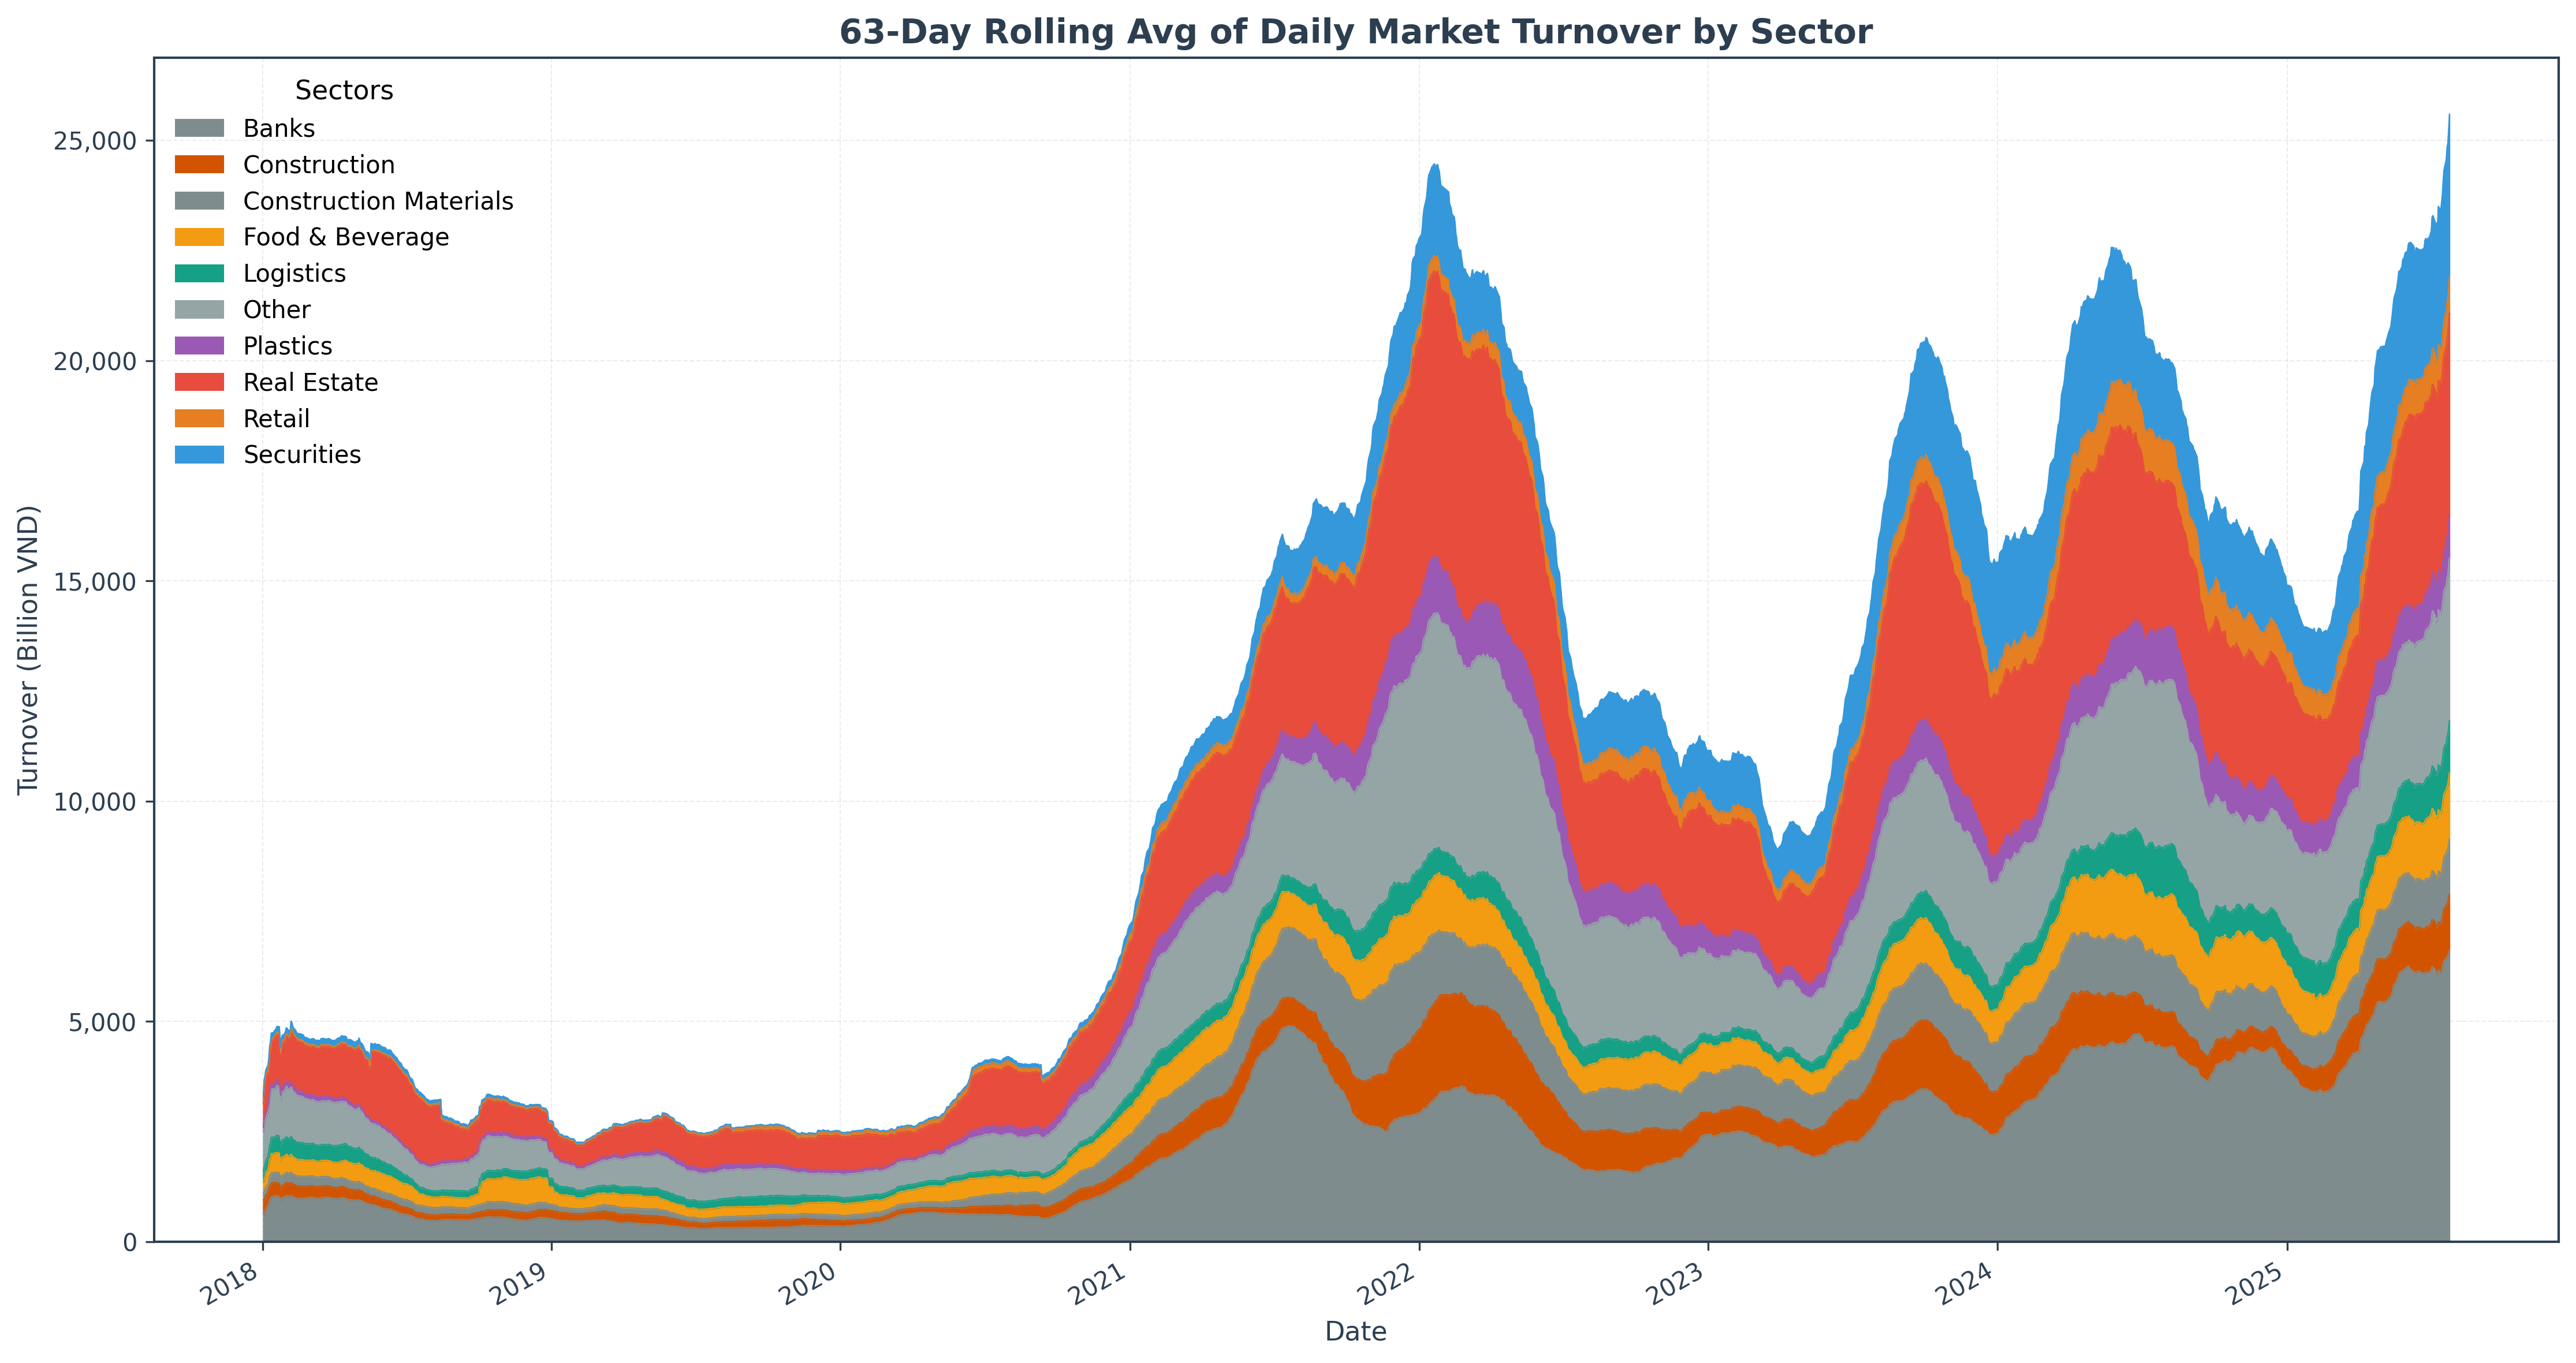


TIER 1 INSIGHTS: MARKET-LEVEL LIQUIDITY TRENDS
• The market experienced significant liquidity growth over the period.
• Average daily turnover started at ~3,279 billion VND in early 2018.
• Liquidity peaked around July 2025 at ~25,594 billion VND per day.
• The current (end of period) average daily turnover is ~25,594 billion VND.

**Sector Dominance (Average % of Total Liquidity):**
  - Real Estate              : 23.6%
  - Other                    : 19.4%
  - Banks                    : 18.9%
  - Food & Beverage          : 7.5%
  - Securities               : 6.9%


In [11]:
# ============================================================================
# CELL 2: TIER 1 - MARKET-LEVEL LIQUIDITY ANALYSIS
# ============================================================================

print("Tier 1 Analysis: Calculating and plotting market-level liquidity trends by sector...")

# --- 1. Aggregate Turnover by Sector and Date ---
sector_turnover_daily = liquidity_df.groupby(['trading_date', 'sector'])['turnover_bn_vnd'].sum().unstack(fill_value=0)

# --- 2. Group smaller sectors into 'Other' for readability ---
# Identify top 9 sectors by total turnover
top_sectors = sector_turnover_daily.sum().nlargest(9).index
# Create 'Other' category
sector_turnover_daily['Other'] = sector_turnover_daily.drop(columns=top_sectors).sum(axis=1)
# Keep only top sectors + 'Other'
sector_turnover_top = sector_turnover_daily[top_sectors.union(['Other'])]

# --- 3. Calculate Rolling Average for Smoothing ---
rolling_window = ANALYSIS_CONFIG['rolling_window_days']
sector_turnover_rolling = sector_turnover_top.rolling(window=rolling_window, min_periods=1).mean()

# --- 4. Create the Stacked Area Chart ---
fig, ax = plt.subplots(figsize=(15, 8))

# Use a color palette that maps to our top sectors
colors = [SECTOR_PALETTE.get(sector, FACTOR_COLORS['Neutral']) for sector in sector_turnover_rolling.columns]

sector_turnover_rolling.plot.area(ax=ax, stacked=True, linewidth=0.5, color=colors)

# --- Formatting ---
ax.set_title(f'{rolling_window}-Day Rolling Avg of Daily Market Turnover by Sector', fontweight='bold')
ax.set_ylabel('Turnover (Billion VND)')
ax.set_xlabel('Date')
ax.legend(title='Sectors', loc='upper left')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Format y-axis to be more readable
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

# --- 5. Print Key Insights ---
total_turnover_rolling = sector_turnover_rolling.sum(axis=1)
peak_liquidity_date = total_turnover_rolling.idxmax()
peak_liquidity_value = total_turnover_rolling.max()
start_liquidity = total_turnover_rolling.iloc[0]
end_liquidity = total_turnover_rolling.iloc[-1]

print("\n" + "="*80)
print("TIER 1 INSIGHTS: MARKET-LEVEL LIQUIDITY TRENDS")
print("="*80)
print(f"• The market experienced significant liquidity growth over the period.")
print(f"• Average daily turnover started at ~{start_liquidity:,.0f} billion VND in early 2018.")
print(f"• Liquidity peaked around {peak_liquidity_date.strftime('%B %Y')} at ~{peak_liquidity_value:,.0f} billion VND per day.")
print(f"• The current (end of period) average daily turnover is ~{end_liquidity:,.0f} billion VND.")

# Analyze sector dominance
sector_contribution = sector_turnover_rolling.div(total_turnover_rolling, axis=0)
avg_contribution = sector_contribution.mean().sort_values(ascending=False)

print("\n**Sector Dominance (Average % of Total Liquidity):**")
for sector, pct in avg_contribution.head(5).items():
    print(f"  - {sector:<25}: {pct:.1%}")

Tier 2 Analysis: Calculating market-wide and intra-sector liquidity concentration...


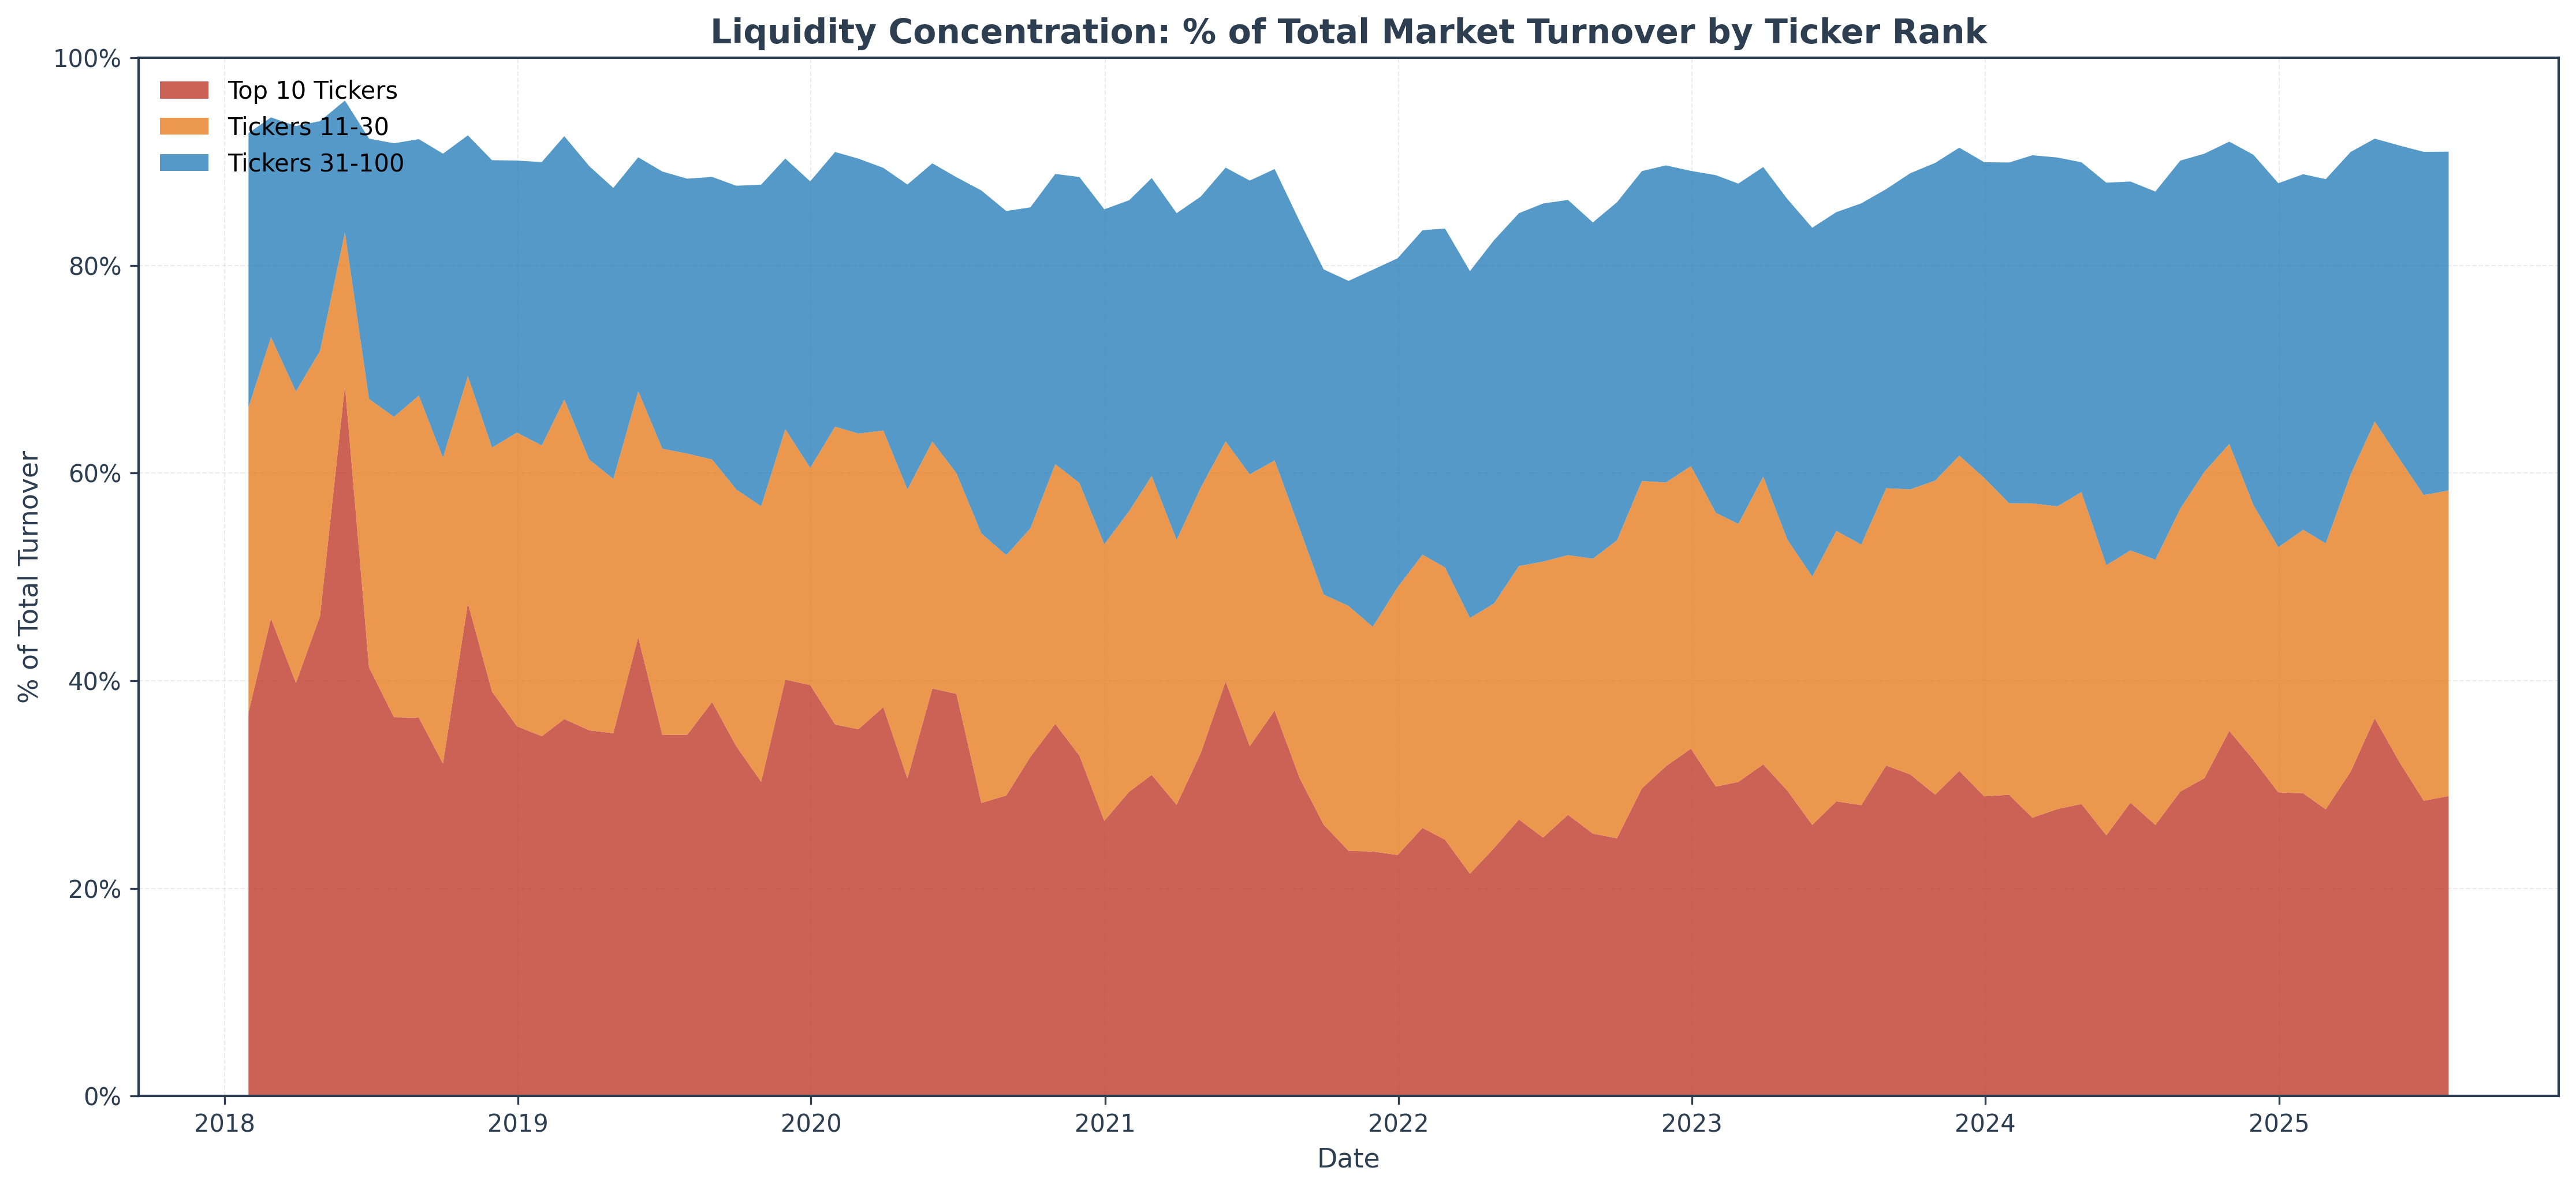

In [12]:
# ============================================================================
# CELL 3: TIER 2 - LIQUIDITY CONCENTRATION ANALYSIS
# ============================================================================

print("Tier 2 Analysis: Calculating market-wide and intra-sector liquidity concentration...")

# --- 1. Calculate Monthly Average Turnover per Ticker ---
# Set 'trading_date' as index for efficient resampling
liquidity_df_indexed = liquidity_df.set_index('trading_date')
monthly_avg_turnover = liquidity_df_indexed.groupby('ticker')['turnover_bn_vnd'].resample('M').mean().reset_index()
monthly_avg_turnover = monthly_avg_turnover.rename(columns={'trading_date': 'month'})

# --- 2. Market-Wide Concentration ---
def calculate_concentration(df, group_col='month'):
    total_turnover_by_group = df.groupby(group_col)['turnover_bn_vnd'].sum()
    
    # Rank tickers within each group
    df['rank'] = df.groupby(group_col)['turnover_bn_vnd'].rank(method='first', ascending=False)
    
    concentration_data = []
    top_n_tiers = ANALYSIS_CONFIG['concentration_top_n'] # [10, 30, 100]
    
    for n in top_n_tiers:
        top_n_turnover = df[df['rank'] <= n].groupby(group_col)['turnover_bn_vnd'].sum()
        concentration = (top_n_turnover / total_turnover_by_group * 100).rename(f'Top {n}')
        concentration_data.append(concentration)
        
    return pd.concat(concentration_data, axis=1).fillna(0)

market_concentration = calculate_concentration(monthly_avg_turnover)

# --- 3. Plot Market-Wide Concentration ---
fig, ax = plt.subplots(figsize=(15, 7))

# Plot as stacked area, but calculate the bands first
top_10 = market_concentration['Top 10']
top_11_30 = market_concentration['Top 30'] - market_concentration['Top 10']
top_31_100 = market_concentration['Top 100'] - market_concentration['Top 30']

ax.stackplot(market_concentration.index, top_10, top_11_30, top_31_100, 
             labels=['Top 10 Tickers', 'Tickers 11-30', 'Tickers 31-100'],
             colors=[FACTOR_COLORS['Negative'], FACTOR_COLORS['Drawdown'], FACTOR_COLORS['Sharpe']], alpha=0.8)

ax.set_title('Liquidity Concentration: % of Total Market Turnover by Ticker Rank', fontweight='bold')
ax.set_ylabel('% of Total Turnover')
ax.set_xlabel('Date')
ax.set_ylim(0, 100)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))
ax.legend(loc='upper left')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

In [13]:
# --- 4. Intra-Sector Concentration Analysis ---
print("\n" + "="*80)
print("TIER 2 INSIGHTS: INTRA-SECTOR LIQUIDITY CONCENTRATION")
print("="*80)

key_sectors = ['Real Estate', 'Banks', 'Securities']
sector_concentration_summary = {}

# Merge sector info back for this analysis
monthly_avg_turnover_sector = monthly_avg_turnover.merge(
    liquidity_df[['ticker', 'sector']].drop_duplicates(), on='ticker', how='left'
)

for sector in key_sectors:
    sector_df = monthly_avg_turnover_sector[monthly_avg_turnover_sector['sector'] == sector]
    if not sector_df.empty:
        # Calculate concentration within the sector
        total_sector_turnover = sector_df.groupby('month')['turnover_bn_vnd'].sum()
        top_3_turnover = sector_df[sector_df.groupby('month')['turnover_bn_vnd'].rank(method='first', ascending=False) <= 3].groupby('month')['turnover_bn_vnd'].sum()
        
        concentration_pct = (top_3_turnover / total_sector_turnover * 100).mean()
        sector_concentration_summary[sector] = concentration_pct
        print(f"• **{sector} Sector:** On average, the top 3 tickers account for **{concentration_pct:.1f}%** of the entire sector's liquidity.")

# --- 5. Overall Insights ---
avg_top_10_pct = market_concentration['Top 10'].mean()
avg_top_30_pct = market_concentration['Top 30'].mean()
avg_top_100_pct = market_concentration['Top 100'].mean()

print("\n**Market-Wide Concentration (Average):**")
print(f"  - The top 10 tickers consistently represent ~**{avg_top_10_pct:.1f}%** of total market liquidity.")
print(f"  - The top 30 tickers (VN30 equivalent) represent ~**{avg_top_30_pct:.1f}%**.")
print(f"  - The top 100 tickers represent ~**{avg_top_100_pct:.1f}%**, leaving a long tail of less liquid stocks.")


TIER 2 INSIGHTS: INTRA-SECTOR LIQUIDITY CONCENTRATION
• **Real Estate Sector:** On average, the top 3 tickers account for **40.2%** of the entire sector's liquidity.
• **Banks Sector:** On average, the top 3 tickers account for **44.4%** of the entire sector's liquidity.
• **Securities Sector:** On average, the top 3 tickers account for **61.4%** of the entire sector's liquidity.

**Market-Wide Concentration (Average):**
  - The top 10 tickers consistently represent ~**32.3%** of total market liquidity.
  - The top 30 tickers (VN30 equivalent) represent ~**58.5%**.
  - The top 100 tickers represent ~**88.4%**, leaving a long tail of less liquid stocks.


Tier 3 Analysis: Calculating the impact of ADTV thresholds on the investable universe...


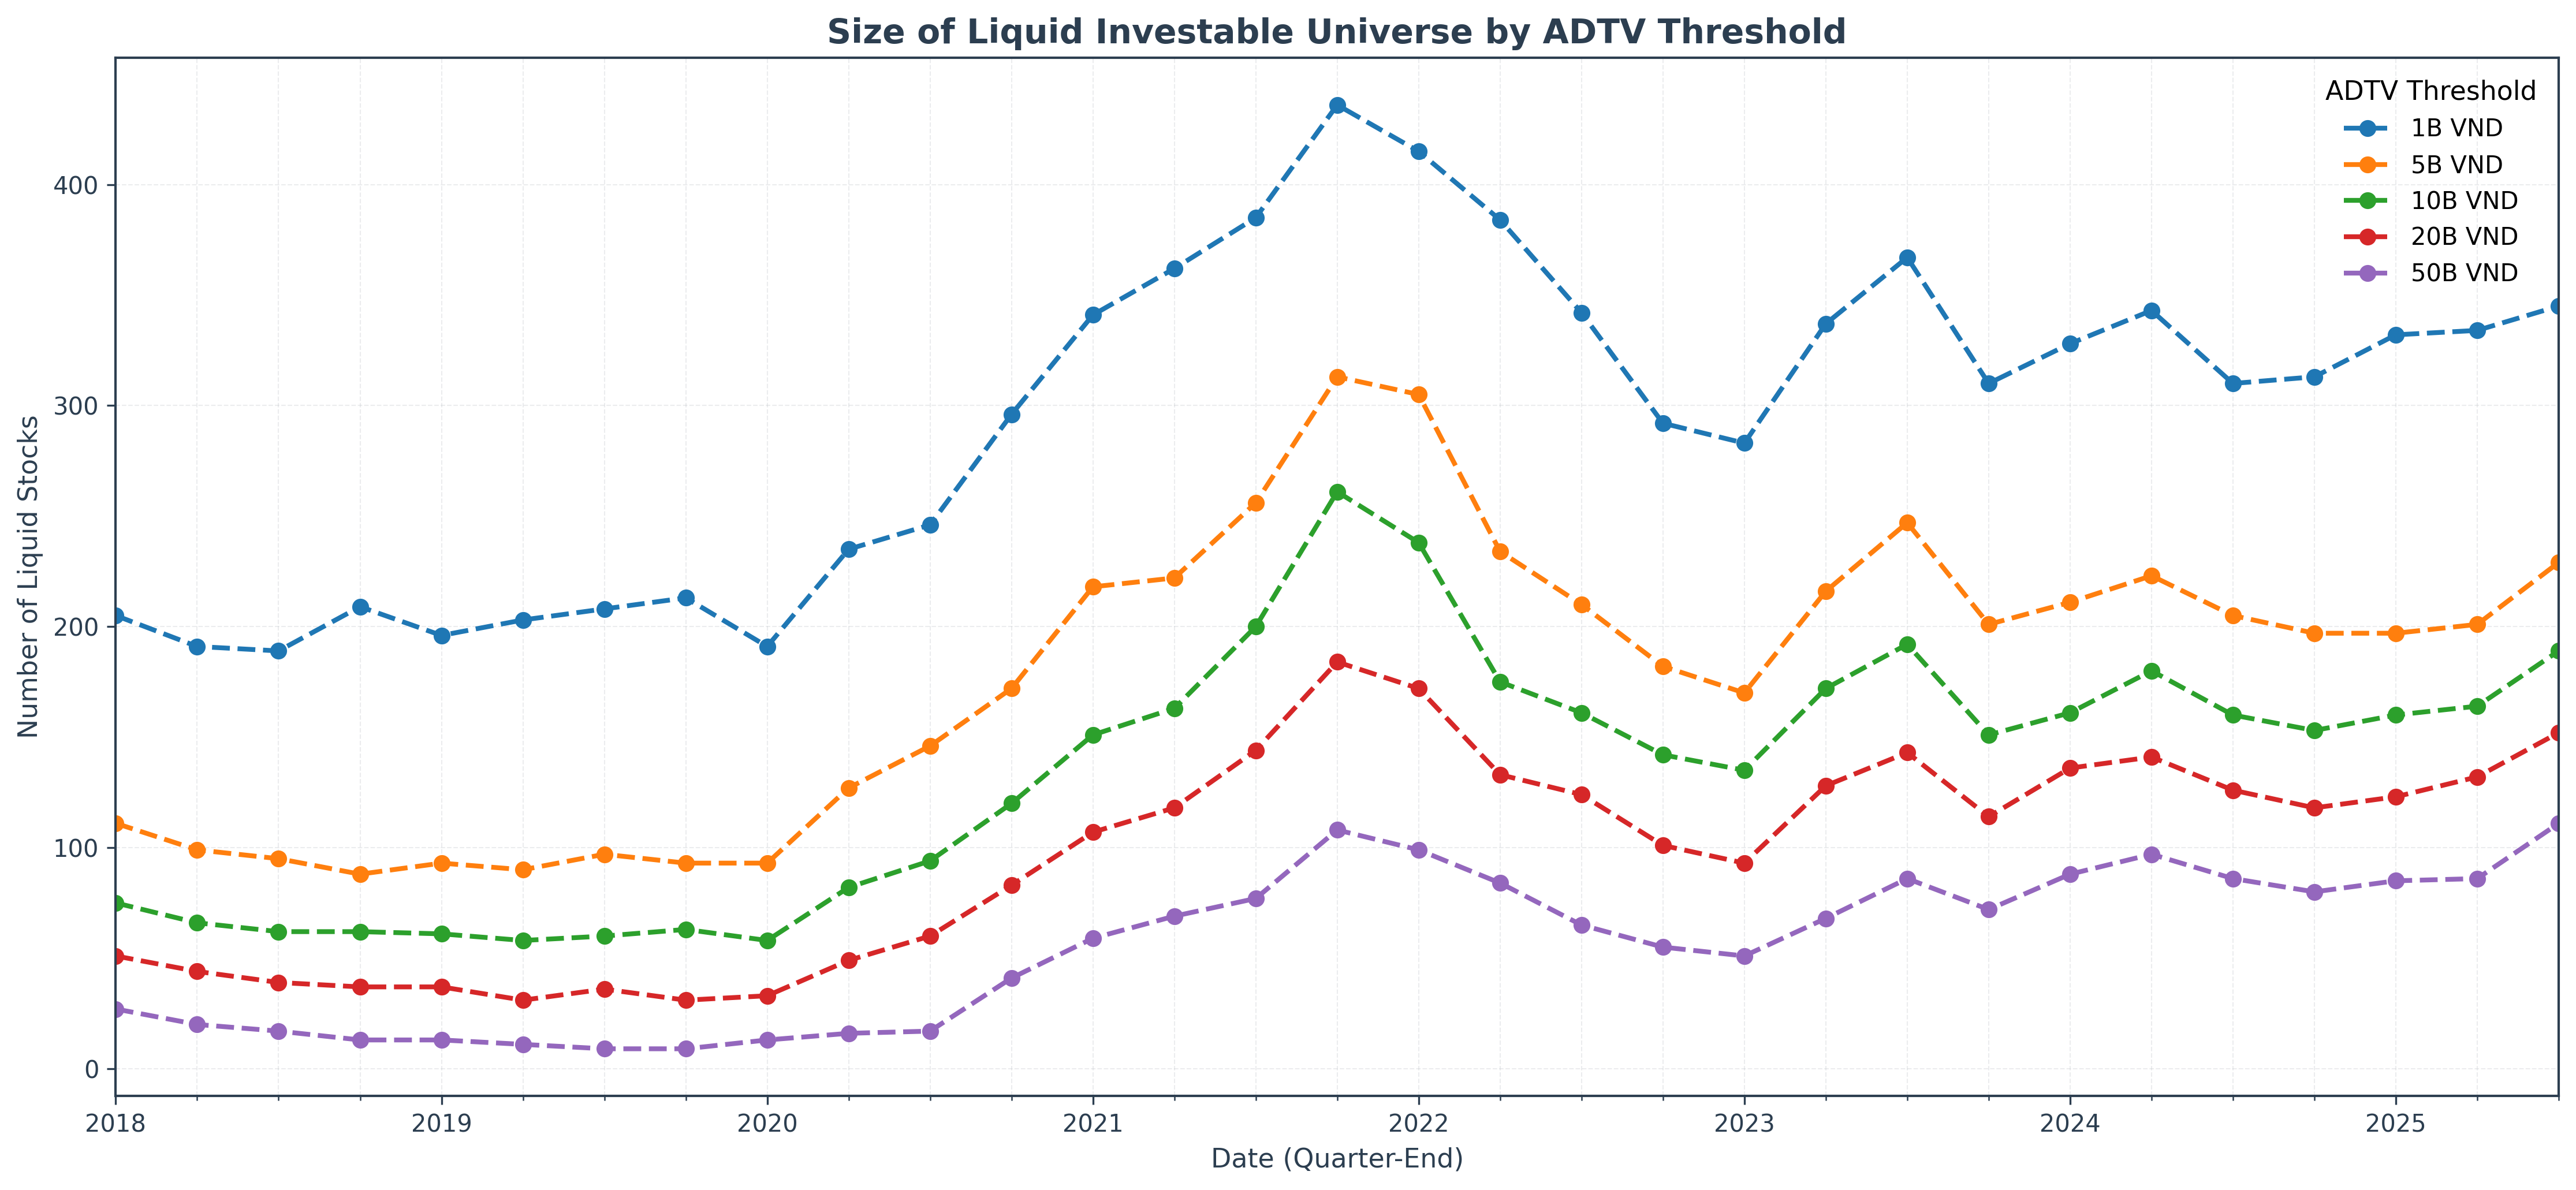

In [14]:
# ============================================================================
# CELL 4: TIER 3 - UNIVERSE ATTRITION ANALYSIS
# ============================================================================

print("Tier 3 Analysis: Calculating the impact of ADTV thresholds on the investable universe...")

# --- 1. Prepare Data for Quarterly ADTV Calculation ---
# Use the monthly average turnover we already calculated for efficiency
adtv_quarterly = monthly_avg_turnover.copy()
adtv_quarterly['quarter'] = pd.to_datetime(adtv_quarterly['month']).dt.to_period('Q')

# Calculate 3-month (1 quarter) ADTV for each stock at each quarter end
quarterly_adtv = adtv_quarterly.groupby(['ticker', 'quarter'])['turnover_bn_vnd'].mean().reset_index()
quarterly_adtv = quarterly_adtv.rename(columns={'turnover_bn_vnd': 'adtv_bn_vnd'})

# --- 2. Calculate Universe Size for Each Threshold Over Time ---
thresholds_bn_vnd = ANALYSIS_CONFIG['adtv_thresholds_bn_vnd']
universe_size_data = []

for threshold in thresholds_bn_vnd:
    # Filter for stocks meeting the threshold
    liquid_stocks = quarterly_adtv[quarterly_adtv['adtv_bn_vnd'] >= threshold]
    # Count the number of liquid stocks in each quarter
    universe_size = liquid_stocks.groupby('quarter')['ticker'].nunique().rename(f'{threshold}B VND')
    universe_size_data.append(universe_size)

universe_size_df = pd.concat(universe_size_data, axis=1).fillna(0)
universe_size_df.index = universe_size_df.index.to_timestamp() # Convert PeriodIndex to DatetimeIndex for plotting

# --- 3. Plot Universe Size Over Time ---
fig, ax = plt.subplots(figsize=(15, 7))
universe_size_df.plot(ax=ax, marker='o', linestyle='--')

ax.set_title('Size of Liquid Investable Universe by ADTV Threshold', fontweight='bold')
ax.set_ylabel('Number of Liquid Stocks')
ax.set_xlabel('Date (Quarter-End)')
ax.legend(title='ADTV Threshold')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

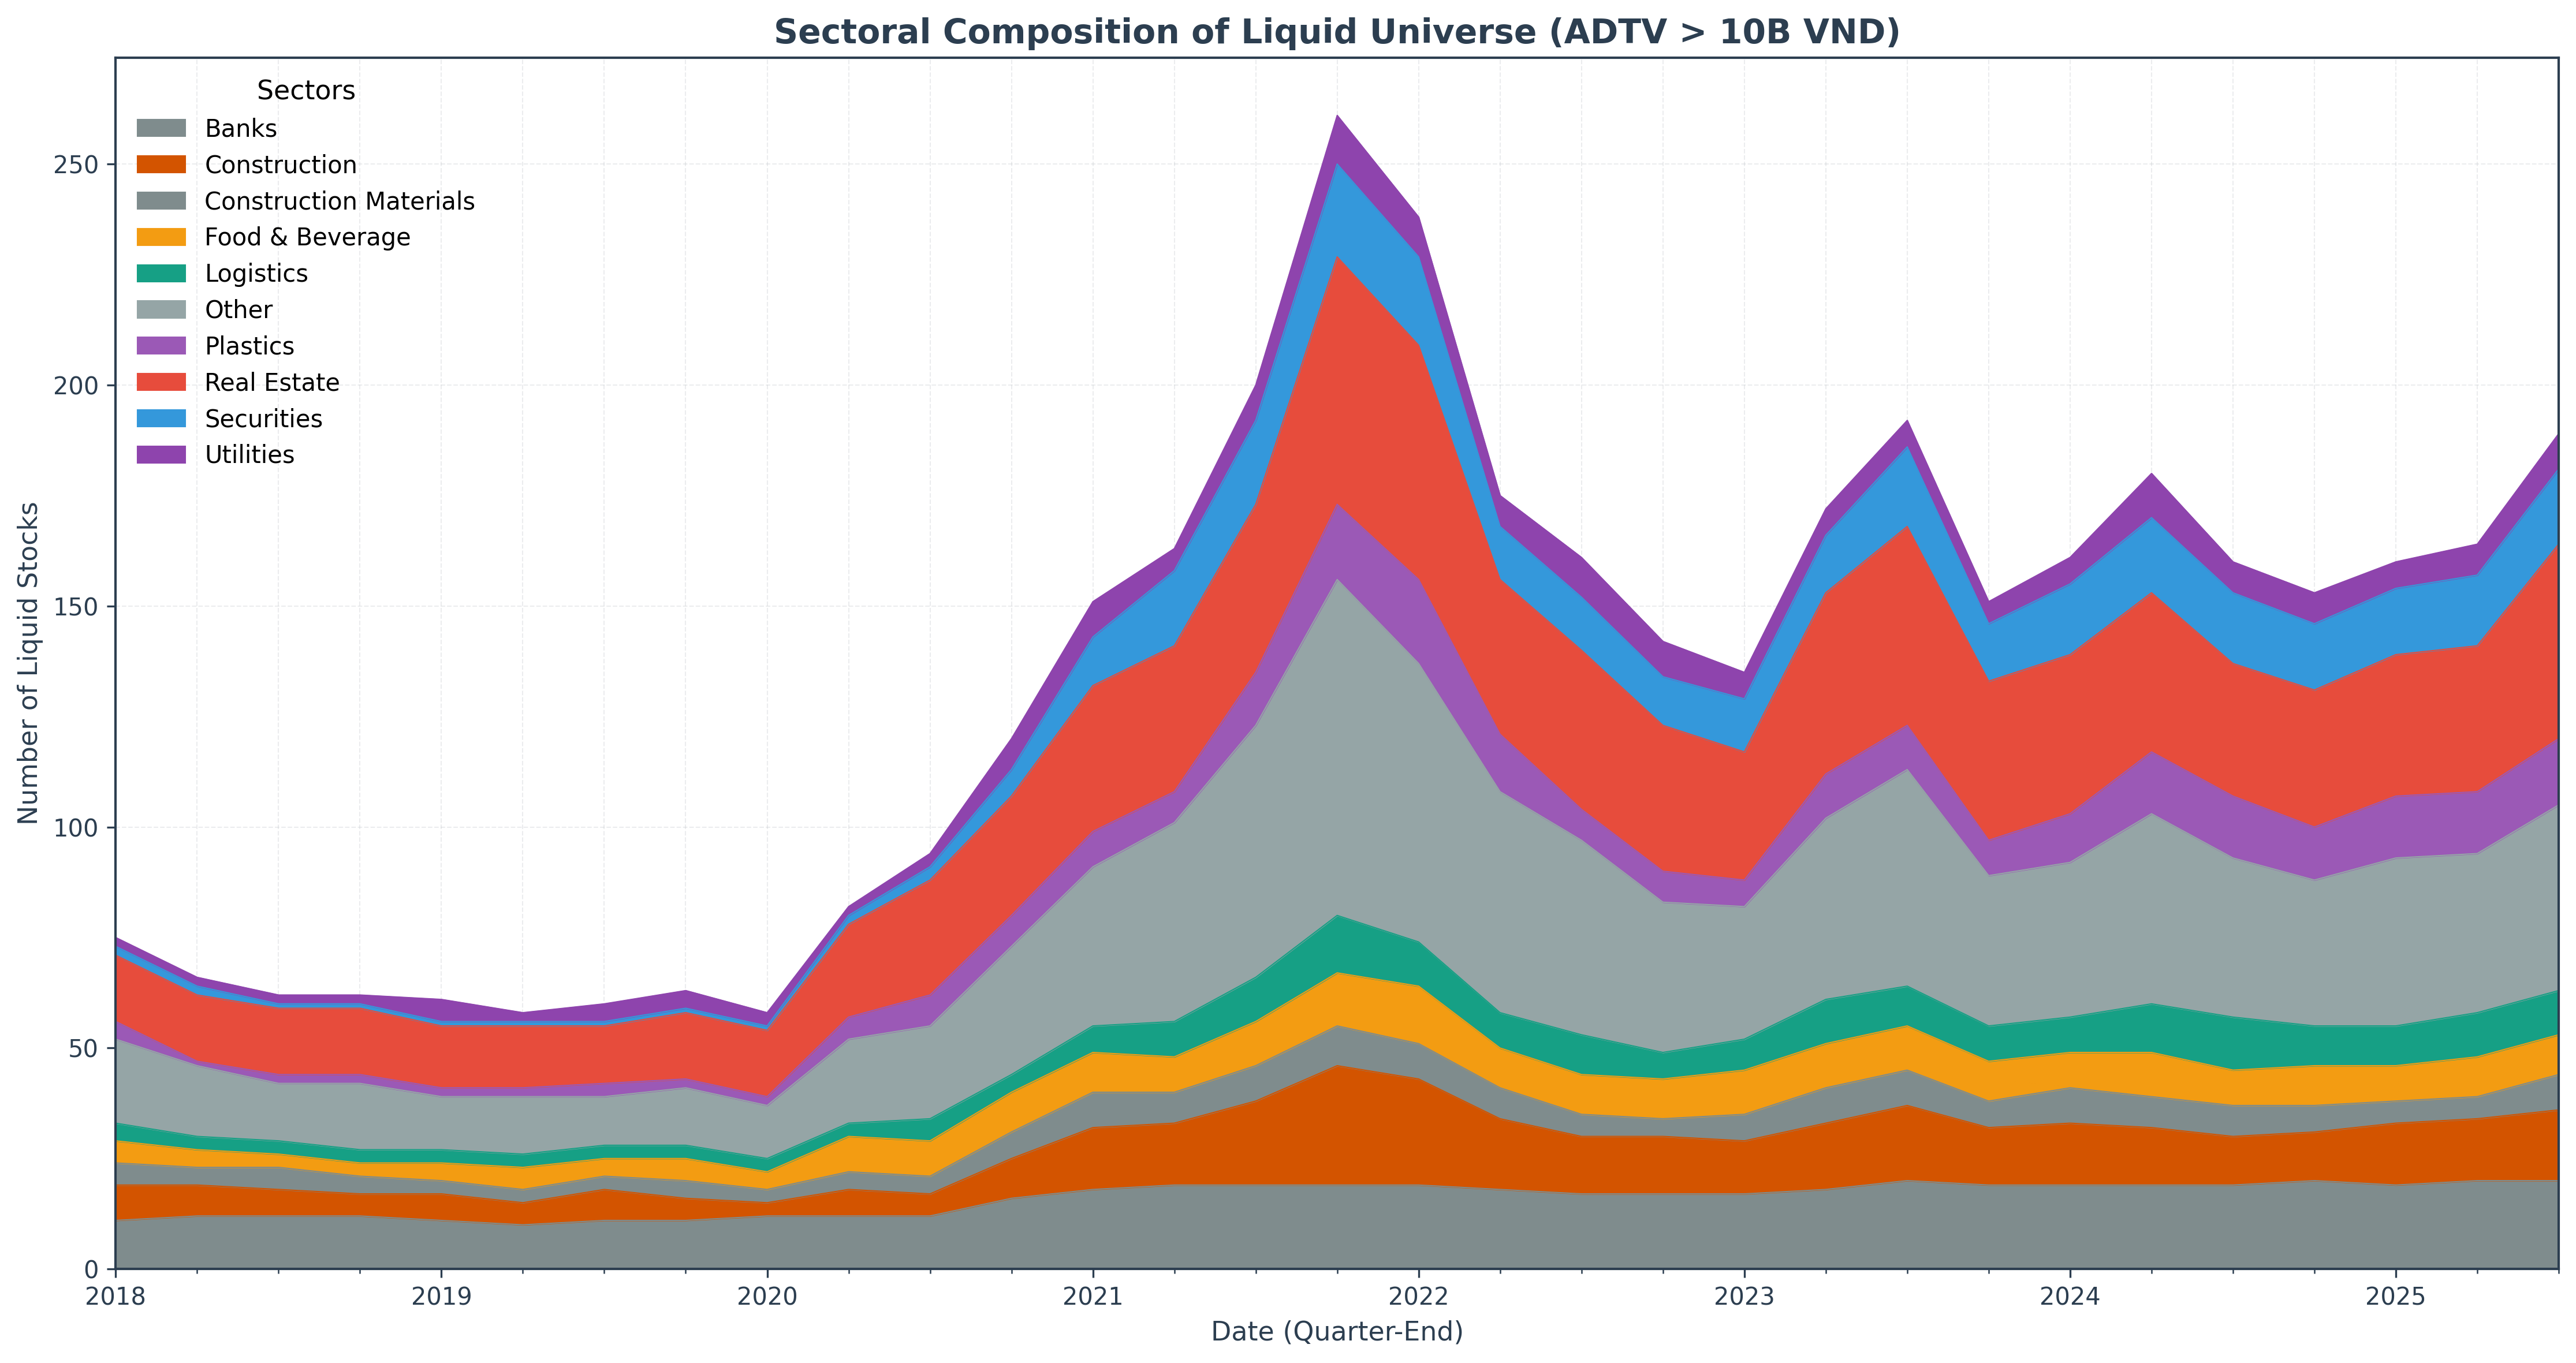

In [15]:
# --- 4. Analyze Sectoral Composition for our Target Threshold (10B VND) ---
target_threshold = 10  # Our proposed 10B VND threshold
liquid_universe_target = quarterly_adtv[quarterly_adtv['adtv_bn_vnd'] >= target_threshold]

# Merge with sector info
liquid_universe_target = liquid_universe_target.merge(
    liquidity_df[['ticker', 'sector']].drop_duplicates(), on='ticker', how='left'
)

# Count stocks per sector in each quarter
sector_composition = liquid_universe_target.groupby(['quarter', 'sector'])['ticker'].nunique().unstack(fill_value=0)

# Group smaller sectors into 'Other'
top_sectors_comp = sector_composition.sum().nlargest(9).index
sector_composition['Other'] = sector_composition.drop(columns=top_sectors_comp).sum(axis=1)
sector_composition_top = sector_composition[top_sectors_comp.union(['Other'])]
sector_composition_top.index = sector_composition_top.index.to_timestamp()

# --- 5. Plot Sectoral Composition Over Time ---
fig, ax = plt.subplots(figsize=(15, 8))
sector_composition_top.plot.area(ax=ax, stacked=True, linewidth=0.5, 
                                 color=[SECTOR_PALETTE.get(c, FACTOR_COLORS['Neutral']) for c in sector_composition_top.columns])

ax.set_title(f'Sectoral Composition of Liquid Universe (ADTV > {target_threshold}B VND)', fontweight='bold')
ax.set_ylabel('Number of Liquid Stocks')
ax.set_xlabel('Date (Quarter-End)')
ax.legend(title='Sectors', loc='upper left')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [16]:
# --- 6. Print Key Insights ---
print("\n" + "="*80)
print("TIER 3 INSIGHTS: UNIVERSE ATTRITION & COMPOSITION")
print("="*80)
avg_universe_size_10b = universe_size_df[f'{target_threshold}B VND'].mean()
print(f"• **Target Threshold (10B VND):** On average, a 10B VND ADTV threshold provides an investable universe of **~{avg_universe_size_10b:.0f} stocks**.")
print(f"  - This universe size ranged from a low of ~{universe_size_df[f'{target_threshold}B VND'].min():.0f} to a high of ~{universe_size_df[f'{target_threshold}B VND'].max():.0f} stocks.")

avg_sector_dist = (sector_composition_top.div(sector_composition_top.sum(axis=1), axis=0)).mean().sort_values(ascending=False)
print("\n**Average Sectoral Composition of the 10B VND Liquid Universe:**")
for sector, pct in avg_sector_dist.head(5).items():
    print(f"  - {sector:<25}: {pct:.1%}")

print("\nThis analysis allows us to select a threshold that balances the need for liquidity with the need for a sufficiently large and diversified universe for our alpha engine to operate on.")


TIER 3 INSIGHTS: UNIVERSE ATTRITION & COMPOSITION
• **Target Threshold (10B VND):** On average, a 10B VND ADTV threshold provides an investable universe of **~134 stocks**.
  - This universe size ranged from a low of ~58 to a high of ~261 stocks.

**Average Sectoral Composition of the 10B VND Liquid Universe:**
  - Other                    : 23.7%
  - Real Estate              : 22.4%
  - Banks                    : 13.3%
  - Construction             : 8.6%
  - Securities               : 6.3%

This analysis allows us to select a threshold that balances the need for liquidity with the need for a sufficiently large and diversified universe for our alpha engine to operate on.
